In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
# Train the ML model
from models import Tomoscope
from utils import plot_loss
from utils import fast_tensor_load_encdec

import time
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


In [3]:
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# Initialize parameters
data_dir = './tomo_data/datasets_tomoscope_TF_24-03-23/'

timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
timestamp = 'tomoscope_test'
print('Using timestamp: ', timestamp)



Using timestamp:  tomoscope_test


In [46]:
# Data specific
IMG_OUTPUT_SIZE = 128

# Train specific
# train_cfg = {
#     'epochs': 10, 'output_turns': 10,
#     'cropping': [0, 0],
#     'enc_dense_layers': [1024, 256],
#     'dec_dense_layers': [1024],
#     'enc_filters': [4, 8, 16],
#     'dec_filters': [8, 16, 10],
#     'enc_kernel_size': 3,
#     'dec_kernel_size': 3,
#     'enc_strides': [2, 2],
#     'dec_strides': [2, 2],
#     'enc_activation': 'relu',
#     'dec_activation': 'relu',
#     'enc_pooling': None, 'dec_pooling': None,
#     'enc_pooling_size': [0, 0], 'dec_pooling_size': [0, 0],
#     'enc_pooling_strides': [1, 1], 'dec_pooling_strides': [1, 1],
#     'enc_pooling_padding': 'valid', 'dec_pooling_padding': 'valid',
#     'enc_dropout': 0.0, 'dec_dropout': 0.0,
#     'metrics': [], 'use_bias': False, 'batchnorm': False,
#     'learning_rate': 1e-3,
#     'dataset%': 0.1,
#     'normalization': 'minmax', 'img_normalize': 'off',
#     'ps_normalize': 'off',
#     'batch_size': 32
# }


# Train specific
train_cfg = {
    'epochs': 10, 'output_turns': 1,
    'cropping': [0, 0],
    'enc_filters': [16, 32, 64, 128],
    'dec_filters': [64, 32, 16],
    'enc_kernel_size': 4,
    'dec_kernel_size': 4,
    'enc_strides': [2, 2],
    'dec_strides': [2, 2],
    'enc_activation': 'relu',
    'dec_activation': 'relu',
    'enc_conv_padding': 'same', 'dec_conv_padding': 'same',
    'enc_dropout': 0.0, 'dec_dropout': 0.0,
    'metrics': [], 'use_bias': False, 'batchnorm': False,
    'learning_rate': 1e-3,
    'dataset%': 0.1,
    'normalization': 'minmax', 'img_normalize': 'off',
    'ps_normalize': 'off',
    'batch_size': 32
}


In [43]:
# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')

# create the directory to store the results
os.makedirs(trial_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)


assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'
assert train_cfg['ps_normalize'] == 'off'

TRAINING_PATH = os.path.join(ML_dir, 'tomoscope-training-??.npz')
VALIDATION_PATH = os.path.join(ML_dir, 'tomoscope-validation-??.npz')

x_train, turn_train, latent_train, y_train = fast_tensor_load_encdec(
    TRAINING_PATH, train_cfg['dataset%'])
print('Number of Training files: ', len(y_train))

x_valid, turn_valid, latent_valid, y_valid = fast_tensor_load_encdec(
    VALIDATION_PATH, train_cfg['dataset%'])
print('Number of Validation files: ', len(y_valid))

y_train = y_train[:, :, :, :train_cfg['output_turns']]
y_valid = y_valid[:, :, :, :train_cfg['output_turns']]

Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-training-00.npz
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-training-01.npz
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-training-02.npz
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-training-03.npz
Number of Training files:  1589
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-validation-00.npz
Number of Validation files:  140


In [44]:
print('Training data shape: ', x_train.shape, y_train.shape)
print('turns data shape: ', turn_train.shape)
print('latent data shape: ', latent_train.shape)

Training data shape:  (1589, 128, 128, 1) (1589, 128, 128, 1)
turns data shape:  (1589, 10)
latent data shape:  (1589, 7)


In [ ]:
%matplotlib inline
# plot some of the outputs

nrows = 3
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    # ax.set_title(f'{title}')


In [47]:
from models import Tomoscope
# Model instantiation
start_t = time.time()
input_shape = x_train.shape[1:]
models = {}

print(f'\n---- Initializing model ----\n')

tomoscope = Tomoscope(input_shape=input_shape, **train_cfg)
print(tomoscope.model.summary())
print(
    f'\n---- Model has been initialized, elapsed: {time.time() - start_t} ----\n')



---- Initializing model ----

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 crop (Cropping2D)              (None, 128, 128, 1)  0           ['input[0][0]']                  
                                                                                                  
 encoder_cnn_1 (Sequential)     (None, 64, 64, 16)   256         ['crop[0][0]']                   
                                                                                                  
 encoder_cnn_2 (Sequential)     (None, 32, 32, 32)   8192    

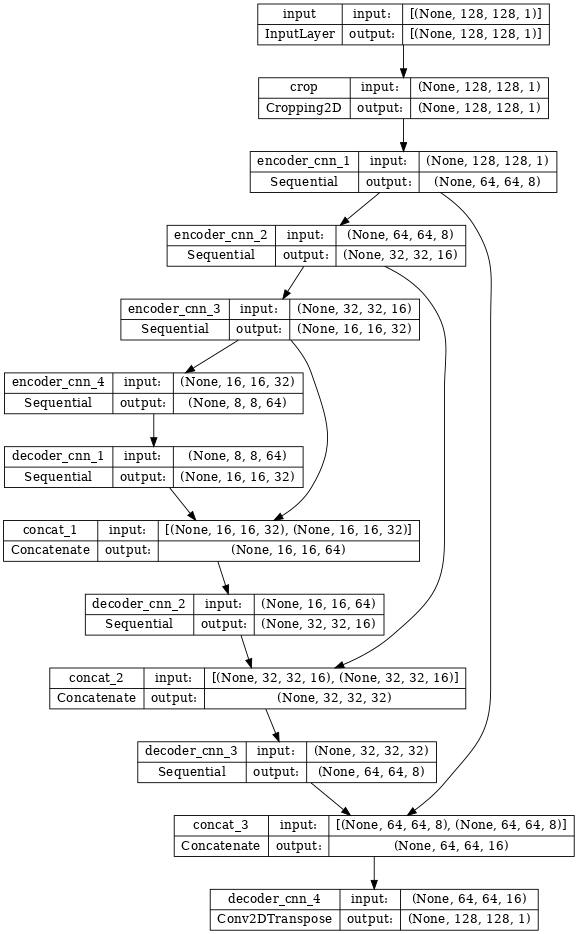

In [35]:
tf.keras.utils.plot_model(tomoscope.model, show_shapes=True, dpi=64)


In [ ]:

print(f'\n---- Training the model ----\n')

# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'tomoscope.h5'),
                                            monitor='val_loss', save_best_only=True)

start_time = time.time()

history = tomoscope.model.fit(
    x=x_train, y=y_train, 
    epochs=train_cfg['epochs'],
    validation_data=(x_valid, y_valid),
    callbacks=[save_best], 
    batch_size=train_cfg['batch_size'],
    verbose=0)

total_time = time.time() - start_time
print(
    f'\n---- Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')


In [44]:
print(custom_loss(y_train[0:1], tomoscope.model(x_train[0:1])))
print(np.mean(tf.keras.metrics.mean_squared_error(y_train[0:1], tomoscope.model(x_train[0:1]))))

tf.Tensor(0.8296597, shape=(), dtype=float32)
0.008987858


In [45]:
%matplotlib inline

# Plot training and validation loss
print('\n---- Plotting loss ----\n')

train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
            title='Tomoscpe Train/Validation Loss',
            figname=os.path.join(plots_dir, 'tomoscope_train_valid_loss.png'))


---- Plotting loss ----



In [ ]:
# save file with experiment configuration
config_dict = {}
config_dict['tomoscope'] = train_cfg.copy()
config_dict['tomoscope'].update({
    'min_train_loss': float(np.min(train_loss_l)),
    'min_valid_loss': float(np.min(valid_loss_l)),
    'total_train_time': total_time,
    'used_gpus': 0
})

# save config_dict
with open(os.path.join(trial_dir, 'tomoscope-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)
